In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load and preprocess data
# df = pd.read_csv('../data/raw/uav_hugging_face.csv')
df = pd.read_csv('../data/processed/uav_remain_80.csv')
data = df[['tx', 'ty', 'tz']].values
timestamps = df['timestamp'].values - df['timestamp'].min()


In [4]:
# Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [5]:
# Prepare sequences (using 10 timesteps to predict next position)
seq_length = 10
X, y = [], []
for i in range(len(data_normalized) - seq_length):
    X.append(data_normalized[i:i+seq_length])
    y.append(data_normalized[i+seq_length])

X = torch.FloatTensor(np.array(X)).to(device)
y = torch.FloatTensor(np.array(y)).to(device)

In [15]:
X

tensor([[[0.9279, 0.2379, 0.5078],
         [0.6382, 0.0450, 0.6770],
         [0.6329, 0.9794, 0.7630],
         ...,
         [0.3031, 0.9704, 0.6188],
         [0.8451, 0.7328, 0.6806],
         [0.9100, 0.0828, 0.6704]],

        [[0.6382, 0.0450, 0.6770],
         [0.6329, 0.9794, 0.7630],
         [0.6232, 0.6267, 0.5930],
         ...,
         [0.8451, 0.7328, 0.6806],
         [0.9100, 0.0828, 0.6704],
         [0.2482, 0.9527, 0.5851]],

        [[0.6329, 0.9794, 0.7630],
         [0.6232, 0.6267, 0.5930],
         [0.8035, 0.5723, 0.5631],
         ...,
         [0.9100, 0.0828, 0.6704],
         [0.2482, 0.9527, 0.5851],
         [0.8643, 0.0609, 0.9300]],

        ...,

        [[0.9813, 0.8960, 0.9980],
         [0.9676, 0.9360, 0.8106],
         [0.7941, 0.9868, 0.7454],
         ...,
         [0.1267, 0.9146, 0.6256],
         [0.8988, 0.2579, 0.4627],
         [0.8222, 0.4804, 0.6033]],

        [[0.9676, 0.9360, 0.8106],
         [0.7941, 0.9868, 0.7454],
         [0.

In [ ]:
# Split dat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train

tensor([[[0.0746, 0.1085, 0.7500],
         [0.9730, 0.8408, 0.9533],
         [0.7535, 0.0126, 0.9480],
         ...,
         [0.9676, 0.9360, 0.8106],
         [0.7941, 0.9868, 0.7454],
         [0.8304, 0.9644, 0.9501]],

        [[0.6329, 0.9794, 0.7630],
         [0.6232, 0.6267, 0.5930],
         [0.8035, 0.5723, 0.5631],
         ...,
         [0.9100, 0.0828, 0.6704],
         [0.2482, 0.9527, 0.5851],
         [0.8643, 0.0609, 0.9300]],

        [[0.2900, 0.5660, 0.6630],
         [0.0891, 0.1341, 0.7700],
         [0.6723, 0.3784, 0.4362],
         ...,
         [0.0118, 0.2297, 0.8232],
         [0.9859, 0.9211, 0.8372],
         [0.6802, 0.6540, 0.5847]],

        ...,

        [[0.4361, 0.5335, 0.6962],
         [0.0197, 0.8268, 0.8549],
         [0.3464, 0.4983, 0.6585],
         ...,
         [0.4639, 0.9773, 0.6652],
         [0.2537, 0.9589, 0.5993],
         [0.9071, 0.1768, 0.7375]],

        [[0.8939, 0.9561, 0.1719],
         [0.9128, 0.7783, 0.7853],
         [0.

In [7]:
# Define Neural ODE model
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )
        
    def forward(self, t, x):
        return self.net(x)

class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        self.func = func
        
    def forward(self, x, t):
        return odeint(self.func, x, t)

In [8]:
# Initialize model and optimizer
func = ODEFunc().to(device)
model = NeuralODE(func).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [9]:
# Training
n_epochs = 600
batch_size = 32
t = torch.linspace(0, 1, 2).to(device)  # Integration time

In [10]:
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size, -1]  # Take last position of sequence
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        pred = model(batch_X, t)[-1]  # Take final prediction
        loss = criterion(pred, batch_y)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(X_train):.4f}')


Epoch [10/600], Loss: 0.0032
Epoch [20/600], Loss: 0.0032
Epoch [30/600], Loss: 0.0031
Epoch [40/600], Loss: 0.0031
Epoch [50/600], Loss: 0.0031
Epoch [60/600], Loss: 0.0031
Epoch [70/600], Loss: 0.0031
Epoch [80/600], Loss: 0.0031
Epoch [90/600], Loss: 0.0031
Epoch [100/600], Loss: 0.0031
Epoch [110/600], Loss: 0.0031
Epoch [120/600], Loss: 0.0031
Epoch [130/600], Loss: 0.0031
Epoch [140/600], Loss: 0.0031
Epoch [150/600], Loss: 0.0031
Epoch [160/600], Loss: 0.0031
Epoch [170/600], Loss: 0.0031
Epoch [180/600], Loss: 0.0031
Epoch [190/600], Loss: 0.0031
Epoch [200/600], Loss: 0.0030
Epoch [210/600], Loss: 0.0030
Epoch [220/600], Loss: 0.0030
Epoch [230/600], Loss: 0.0030
Epoch [240/600], Loss: 0.0030
Epoch [250/600], Loss: 0.0030
Epoch [260/600], Loss: 0.0030
Epoch [270/600], Loss: 0.0029
Epoch [280/600], Loss: 0.0029
Epoch [290/600], Loss: 0.0029
Epoch [300/600], Loss: 0.0029
Epoch [310/600], Loss: 0.0029
Epoch [320/600], Loss: 0.0029
Epoch [330/600], Loss: 0.0030
Epoch [340/600], Lo

Test Loss: 0.0948


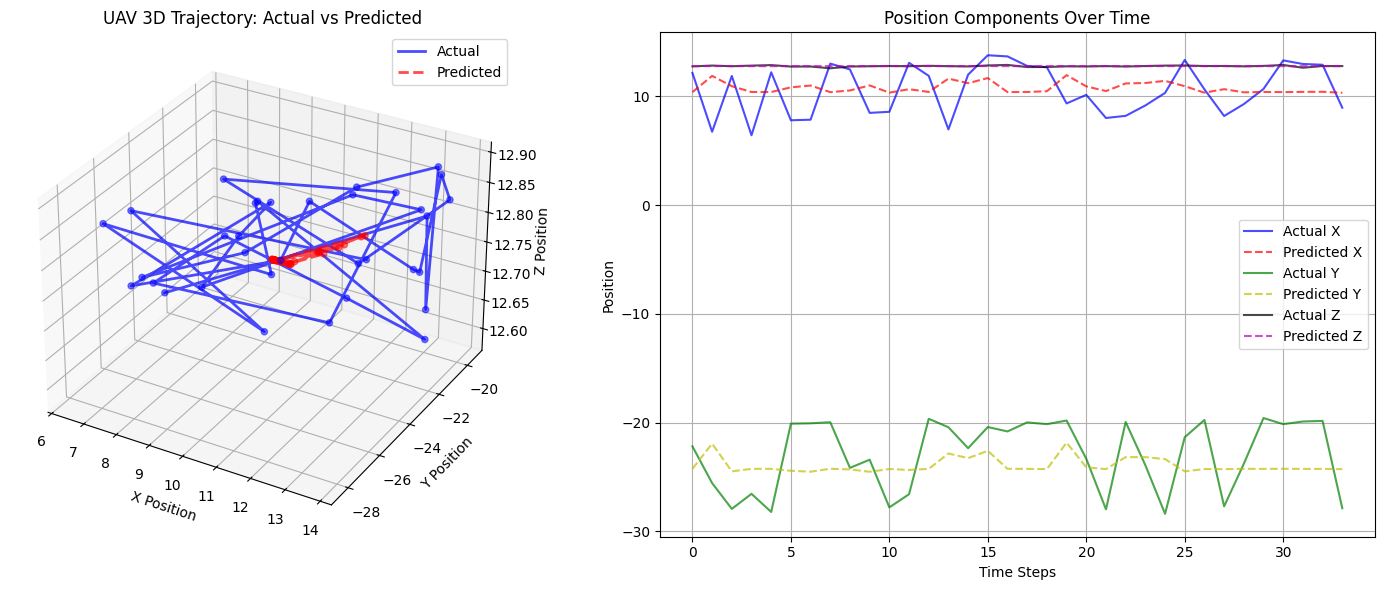


Root Mean Square Error for each dimension:
X-axis RMSE: 2.4806
Y-axis RMSE: 3.3987
Z-axis RMSE: 0.0620


In [11]:
# Testing and visualization
model.eval()
with torch.no_grad():
    test_pred = model(X_test[:, -1], t)[-1]
    test_loss = criterion(test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Move tensors to CPU before numpy conversion
    test_pred = test_pred.cpu()
    y_test = y_test.cpu()

    # Inverse transform predictions for visualization
    test_pred_denorm = scaler.inverse_transform(test_pred.numpy())
    y_test_denorm = scaler.inverse_transform(y_test.numpy())

    # Create figure with two subplots
    fig = plt.figure(figsize=(15, 6))
    
    # 3D trajectory plot
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot lines instead of just scatter points
    ax1.plot(y_test_denorm[:, 0], y_test_denorm[:, 1], y_test_denorm[:, 2], 
             'b-', label='Actual', linewidth=2, alpha=0.7)
    ax1.plot(test_pred_denorm[:, 0], test_pred_denorm[:, 1], test_pred_denorm[:, 2], 
             'r--', label='Predicted', linewidth=2, alpha=0.7)
    
    # Add scatter points to show actual positions
    ax1.scatter(y_test_denorm[:, 0], y_test_denorm[:, 1], y_test_denorm[:, 2], 
                c='blue', s=20, alpha=0.5)
    ax1.scatter(test_pred_denorm[:, 0], test_pred_denorm[:, 1], test_pred_denorm[:, 2], 
                c='red', s=20, alpha=0.5)
    
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_zlabel('Z Position')
    ax1.legend()
    ax1.set_title('UAV 3D Trajectory: Actual vs Predicted')

    # Separate coordinate plots over time
    ax2 = fig.add_subplot(122)
    time_steps = range(len(y_test_denorm))
    
    # Plot each coordinate over time
    ax2.plot(time_steps, y_test_denorm[:, 0], 'b-', label='Actual X', alpha=0.7)
    ax2.plot(time_steps, test_pred_denorm[:, 0], 'r--', label='Predicted X', alpha=0.7)
    ax2.plot(time_steps, y_test_denorm[:, 1], 'g-', label='Actual Y', alpha=0.7)
    ax2.plot(time_steps, test_pred_denorm[:, 1], 'y--', label='Predicted Y', alpha=0.7)
    ax2.plot(time_steps, y_test_denorm[:, 2], 'k-', label='Actual Z', alpha=0.7)
    ax2.plot(time_steps, test_pred_denorm[:, 2], 'm--', label='Predicted Z', alpha=0.7)
    
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Position')
    ax2.legend()
    ax2.set_title('Position Components Over Time')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate and display error metrics
    mse = np.mean((y_test_denorm - test_pred_denorm)**2, axis=0)
    rmse = np.sqrt(mse)
    print("\nRoot Mean Square Error for each dimension:")
    print(f"X-axis RMSE: {rmse[0]:.4f}")
    print(f"Y-axis RMSE: {rmse[1]:.4f}")
    print(f"Z-axis RMSE: {rmse[2]:.4f}")